# KalmanFilter

In [1]:
using Plots, LinearAlgebra, Statistics, Distributions, Random

## define constructor of KalmanFilter
define Equation of state and Equation of observation as follows:
$$
x_k = A_k x_{k-1} + B_k u_k + w_k  \\
z_k = C_k x_k + v_k
$$
$ w_k $ and $ v_k $ is gaussian noise:
$$
w_k \sim  N(0, Q_k)   \\
v_k \sim N(0, R_k)
$$

In [2]:
# constructor of time-invariant system (F,G,H,Q,R is constant)
mutable struct KF
    # system dynamics matrices
    A::Array{Float64}       # EOS
    B::Array{Float64}       # controll
    C::Array{Float64}       # EOO
    Q::Array{Float64}       # Covariace matrix of drive noise
    R::Array{Float64}       # COvariance matix of observation noise
    # old state of system (or initial state at construction)
    x_old::Vector{Float64}
    P_old::Array{Float64}
end
# in case you consider the time-variant system, you have to access the members of this struct consequently
function KF(kf::KF, A, B, C, Q, R)
    # update time-variant system dynamics
    kf.A = A
    kf.B = B
    kf.C = C
    kf.Q = Q
    kf.R = R
    return kf
end

KF

In [3]:
# Equation of State
KF_EoS(kf::KF, x::Vector{Float64}, w=zeros(length(x)), u=zeros(length(x))) = kf.A*x + kf.B*u + w
# Equation of Observation
KF_EoO(kf::KF, x::Vector{Float64}, v=zeros(length(kf.C*x))) = kf.C*x + v

KF_EoO (generic function with 2 methods)

## update of state
Prediction of state:
$$
\hat{\boldsymbol{x}}_{k|k-1} = A_k \hat{\boldsymbol{x}}_{k-1|k-1} + B_k \boldsymbol{u}_{k}  \qquad \textrm{: prediction of state}\\
P_{k|k-1} = A_k P_{k-1|k-1} A_k^T + Q_k  \quad \textrm{: prediction of error matrix}
$$

Update of state:
$$
\boldsymbol{e}_{k} = \boldsymbol{z}_{k} - C_k \hat{\boldsymbol{x}}_{k|k-1}    \quad \textrm{: innovation}\\
S_k = R_k + C_k P_{k|k-1} C_k^T   \quad \textrm{: covariance matrix of innovation}\\
K_k = P_{k|k-1} C_k^T S_k^{-1}      \quad \textrm{: optimal Kalman gain}\\
\hat{\boldsymbol{x}}_{k|k} = \hat{\boldsymbol{x}}_{k|k-1}  + K_k\boldsymbol{e}_{k}     \quad \textrm{: updated state prediction}\\
P_{k|k} = (I-K_kC_k) P_{k|k-1}    \quad \textrm{: updated error matrix}
$$

In [4]:
# Estimation of Stable dynamics (using linear kalman filter) 
# default : no controll variable
function KalmanFilter(kf::KF, x::Vector{Float64}, u=zeros(length(x)))
    @assert length(u)==length(x)
    # Prediction of older filter
    x_predicted = KF_EoS(kf, kf.x_old)
    P_predicted = kf.A * kf.P_old * transpose(kf.A) + kf.Q
    
    # update filter
    C_T = transpose(kf.C)
    e = x - KF_EoO(kf, x_predicted)
    S = kf.R + kf.C * P_predicted * C_T
    Sinv = inv(S)
    K = P_predicted * C_T * Sinv
    x_updated = x_predicted + K*e
    nm = length(kf.x_old)
    eye = Matrix{Float64}(I, nm, nm)
    P_updated = (eye - K*C) * P_predicted
    
    kf.x_old = x_updated
    kf.P_old = P_updated
    return x_updated, P_updated
end

KalmanFilter (generic function with 2 methods)

## example : state estimation of moving trocco
assumptions:
- no control
- time invariant
- accurate initial state

state is represented as :
$$
\boldsymbol{x}_k = 
 \left[\begin{array}{c}
            x_k \\
            \dot{x}_k \\
        \end{array}\right]
$$
acceralation $ a_k \sim N(0,\sigma_a) $ is given between time $k$ and  $k-1$. System dynamics is represented  as :
$$
\boldsymbol{x}_k = A \boldsymbol{x}_{k-1} + G a_k \\
A = 
\left[\begin{array}{cc}
            % 横並びは&を挟む
            1 & \Delta t\\
            0 & 1\\
        \end{array}\right]\\
G = 
 \left[\begin{array}{c}
            \frac{\Delta t^2}{2} \\
             \Delta t\\
         \end{array}\right]  \\
a_k \sim N(0, \sigma_a) \\
Q = Cov(G a_k) = \sigma_a^2 \times
\left[\begin{array}{cc}
            % 横並びは&を挟む
            \frac{\Delta t^4}{4} & \frac{\Delta t^3}{2}\\
            \frac{\Delta t^3}{2} & \Delta t^2\\
        \end{array}\right]
$$
observation of position $ x_k $ is represented by observation error as:
$$
z_k = C \boldsymbol{x}_{k}+\boldsymbol{v}_{k}  \\
C = \left[\begin{array}{cc}
            1 & 0\\
        \end{array}\right]\\
v_k \sim N(0, \sigma_z) \\
R = 
\mathrm{E}\left(\boldsymbol{v}_{k} \boldsymbol{v}_{k}^{\mathrm{T}}\right)=\left[\sigma_{z}^{2}\right]
$$


In [5]:
rng = MersenneTwister(123)
const x₀ = [0., 0.]
const P₀ = [0.01 0. ; 0.01 0.]
const σₐ = 1.
const σ₀ = 1.
const Δt = 0.1              # [sec]
const A = [1. Δt ; 0. 1.]
const B = [1. 0.; 0. 1.]      # not specified because u is zero vector
const G = [Δt^2/2, Δt]
const Q = σₐ^2 * [Δt^4/4 Δt^3/2; Δt^3/2 Δt^2]
const C = [1 0]
const R = [σ₀^2]

1-element Array{Float64,1}:
 1.0

In [40]:
kf = KF(A, B, C, Q, R, x₀, P₀)

KF([1.0 0.1; 0.0 1.0], [1.0 0.0; 0.0 1.0], [1.0 0.0], [2.5e-5 0.0005; 0.0005 0.01], [1.0], [0.0, 0.0], [0.01 0.0; 0.01 0.0])

In [41]:
tspan = 0.:Δt:10.
k = collect(tspan)
state = zeros(length(k),2)
estim = zeros(length(k),2)
obser = zeros(length(k),1)

101×1 Array{Float64,2}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [42]:
for (ind, t) in enumerate(tspan)
    obser[ind,:] = KF_EoO(kf, state[ind,:], [randn(rng)])
    estim[ind,:], newP = KalmanFilter(kf, obser[ind,:])
    state[ind,:] = KF_EoS(kf, kf.x_old, G*randn(rng))
end

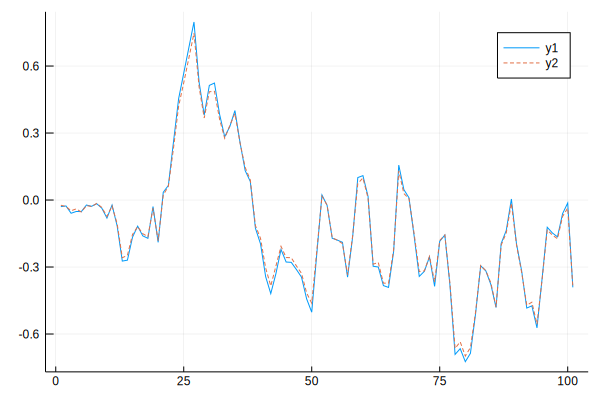

In [51]:
plot(state[:,1])
plot!(estim[:,1], linestyle=:dash)

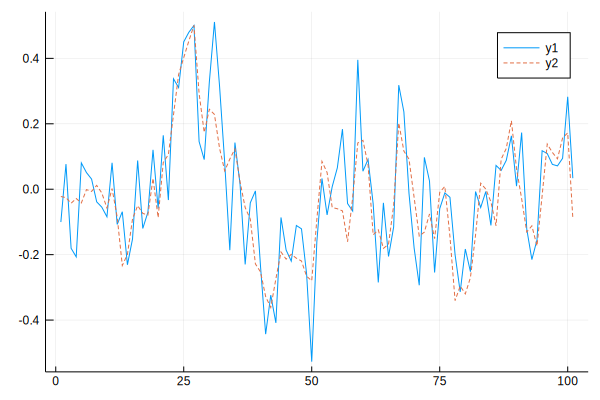

In [53]:
plot(state[:,2])
plot!(estim[:,2], linestyle=:dash)

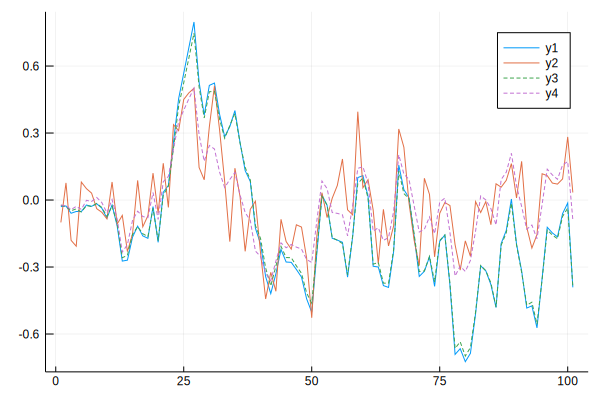

In [54]:
plot(state)
plot!(estim, linestyle=:dash)